# LDA for fake news classification

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb
import scipy.stats as stats

from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

from sklearn.feature_extraction.text import CountVectorizer


from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE




In [92]:
import pandas as pd
data = pd.read_csv('WELFake_Dataset.csv')
#print(data.shape)
sub = data[0:1500] #currently experimenting on subset
sub.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [93]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words
nltk.download('stopwords')
nltk.download('words')

# Define English stopwords from NLTK
nltk_stopwords = set(stopwords.words('english'))

# Define your custom stopwords
custom_stopwords = set(['one', 'bensasse', 'said', 'like', 'right', 'new', 'would', 'told', 'get', 'old', 'going', 'seems', 'lynching', 'also', 'way', 'call','as','per','one','two','could','got','ing'])

# Combine NLTK stopwords with custom stopwords
all_stopwords = nltk_stopwords.union(custom_stopwords)

# Get a set of common English words
english_words = set(words.words())

# Create a WordNetLemmatizer instance
lemmatizer = WordNetLemmatizer()

def preprocess(corpus):
    cleaned_corpus = []
    
    for text in corpus:
        # Lowercase
        text = text.lower()
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove links
        text = re.sub(r'https?://[^\s\n\r]+', '', text)
        # Remove words associated with #
        text = re.sub(r'#\S+', ' ', text)
        # Remove non-alphanumeric characters
        text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
        # Tokenize and remove stopwords
        words = nltk.word_tokenize(text)
        words = [word for word in words if word not in all_stopwords and len(word) > 3 and word in english_words]  # Filter out single letters and meaningless words
        # Lemmatize words
        words = [lemmatizer.lemmatize(word) for word in words]
        # Remove words containing numbers
        words = [word for word in words if not re.search(r'\d', word)]
        cleaned_corpus.append(words)
    
    return cleaned_corpus


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amreshsenathirajah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/amreshsenathirajah/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [94]:
# Use your preprocess function to clean the text
clean_train_comments = preprocess(sub['text'])


#print(clean_train_comments[0])

In [95]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
data = [' '.join(comment) for comment in clean_train_comments]
#data = clean_train_comments

vectorizer = TfidfVectorizer(max_features=1000,
                             stop_words='english',
                             min_df=1,
                             max_df=0.95)

X = vectorizer.fit_transform(data)


num_topics = min(X.shape[1], 5)  # Adjust the number of topics as needed

# Apply Truncated SVD 
lsa = TruncatedSVD(n_components=num_topics)

lsa.fit(X)

# Get the terms (feature names)
terms = vectorizer.get_feature_names_out()

for i, comp in enumerate(lsa.components_):
    terms_in_comp = zip(terms, comp)
    sorted_terms = sorted(terms_in_comp, key=lambda x: x[1], reverse=True)[:25]
    print(f"Topic {i + 1}:")
    for term, weight in sorted_terms:
        print(f"{term}: {weight:.4f}")
    print()



Topic 1:
trump: 0.5370
president: 0.1852
people: 0.1429
state: 0.1126
time: 0.1123
campaign: 0.1082
election: 0.0980
party: 0.0974
republican: 0.0973
house: 0.0967
white: 0.0963
news: 0.0945
government: 0.0942
united: 0.0857
year: 0.0834
country: 0.0793
russia: 0.0785
medium: 0.0770
presidential: 0.0742
twitter: 0.0725
world: 0.0723
political: 0.0689
vote: 0.0652
national: 0.0648
know: 0.0639

Topic 2:
trump: 0.7324
republican: 0.0517
campaign: 0.0508
president: 0.0384
presidential: 0.0364
nominee: 0.0321
featured: 0.0271
candidate: 0.0260
image: 0.0243
twitter: 0.0232
elect: 0.0197
estate: 0.0188
rally: 0.0185
penny: 0.0177
debate: 0.0175
brand: 0.0160
presidency: 0.0153
nomination: 0.0131
adviser: 0.0129
convention: 0.0123
racist: 0.0117
poll: 0.0106
host: 0.0105
great: 0.0101
bush: 0.0096

Topic 3:
police: 0.2704
people: 0.2236
black: 0.1766
twitter: 0.1430
video: 0.1423
know: 0.1035
time: 0.1019
woman: 0.0829
life: 0.0774
really: 0.0739
young: 0.0737
shooting: 0.0726
image: 0.0704


In [96]:
from sklearn.metrics.pairwise import cosine_similarity


lsa_document_vectors = lsa.transform(X)

# Calculate cosine similarity between document vectors
cosine_sim_matrix = cosine_similarity(lsa_document_vectors, lsa_document_vectors)

# Display the cosine similarity matrix
print("Cosine Similarity Matrix:")
print(cosine_sim_matrix)


Cosine Similarity Matrix:
[[1.         0.85244464 0.79818675 ... 0.96221219 0.55474343 0.21901074]
 [0.85244464 1.         0.76579461 ... 0.93049415 0.58824485 0.38587522]
 [0.79818675 0.76579461 1.         ... 0.82754664 0.68773708 0.73630536]
 ...
 [0.96221219 0.93049415 0.82754664 ... 1.         0.68467721 0.32141016]
 [0.55474343 0.58824485 0.68773708 ... 0.68467721 1.         0.61488492]
 [0.21901074 0.38587522 0.73630536 ... 0.32141016 0.61488492 1.        ]]


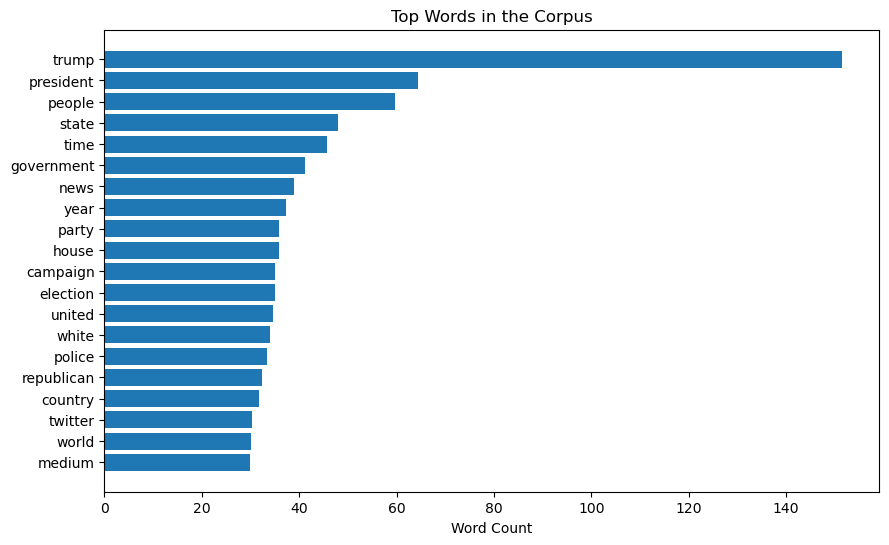

In [97]:

def get_top_n_words(n_top_words, count_vectorizer, text_data):
    vectorized_headlines = count_vectorizer.fit_transform(text_data)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0, :], 1)
    word_values = np.flip(np.sort(vectorized_total)[0, :], 1)

    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i, word_indices[0, i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for
             word in count_vectorizer.inverse_transform(word_vectors)]

    return words, word_values[0, :n_top_words].tolist()[0]

# Choose the number of top words to display
n_top_words = 20


top_words, top_word_values = get_top_n_words(n_top_words, vectorizer, data)

# Plot the top words
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(top_words, top_word_values)
ax.set_title('Top Words in the Corpus')
ax.set_xlabel('Word Count')
ax.invert_yaxis()  #to show most popular words on top
plt.show()
